In [2]:
import sys
sys.path.append('..')
sys.path.append('../author_code/ch06')
import numpy as np
from common.functions import softmax
from rnnlm import Rnnlm
from better_rnnlm import BetterRnnlm


class RnnlmGen(Rnnlm):
    def generate(self, start_id, skip_ids=None, sample_size=100):
        word_ids = [start_id]

        x = start_id
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1, 1)
            score = self.predict(x)
            p = softmax(score.flatten())

            sampled = np.random.choice(len(p), size=1, p=p)
            if (skip_ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x))

        return word_ids

    def get_state(self):
        return self.lstm_layer.h, self.lstm_layer.c

    def set_state(self, state):
        self.lstm_layer.set_state(*state)


In [7]:
import sys
sys.path.append('..')
sys.path.append('../author_code/ch07')
from rnnlm_gen import RnnlmGen
from dataset import ptb


corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = RnnlmGen()
model.load_params('../author_code/ch06/Rnnlm.pkl')

# start文字とskip文字の設定
start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]
# 文章生成
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print(txt)

you 're forcing it.
 he hopes to win their shadow nasd or mr. einhorn battle to cost the board to take control of the three bankruptcy african market but samuel iii is lucky to pay affiliates ' participation in seoul.
 mr. hahn has put out of the thrift urges that ford is n't yet accepted as he underscore petrie yesterday.
 with a regulatory agreement between the issuance of the hospitals and ministry of los angeles advocates expect the most convincing union plane had the major independent takeover as the ads until oct..
 but sharply included takeover-stock


In [8]:
import sys
sys.path.append('..')
from dataset import sequence


(x_train, t_train), (x_test, t_test) = \
    sequence.load_data('addition.txt', seed=1984)
char_to_id, id_to_char = sequence.get_vocab()

print(x_train.shape, t_train.shape)
print(x_test.shape, t_test.shape)
# (45000, 7) (45000, 5)
# (5000, 7) (5000, 5)

print(x_train[0])
print(t_train[0])
# [ 3  0  2  0  0 11  5]
# [ 6  0 11  7  5]

print(''.join([id_to_char[c] for c in x_train[0]]))
print(''.join([id_to_char[c] for c in t_train[0]]))
# 71+118
# _189


(45000, 7) (45000, 5)
(5000, 7) (5000, 5)
[ 3  0  2  0  0 11  5]
[ 6  0 11  7  5]
71+118 
_189 


In [21]:
import sys
sys.path.append('..')
from common.time_layers import *
from common.base_model import BaseModel

class Encoder(object):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        
        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False)
        
        self.params = self.embed.params + self.lstm.params
        self.grads = self.embed.grads + self.lstm.grads 
        self.hs = None
        
    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        self.hs = hs
        return hs[:, -1, :]
    
    def backward(self, dh):
        dhs = np.zeros_like(self.hs)
        dhs[:, -1, :] = dh
        
        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout
    
    
class Decoder(object):
    def __init__(self, vacab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False)
        self.affine = TimeAffine(affine_W, affine_b)
        
        self.params, self.grads = [], []
        
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads
            
    def forward(self, xs, h):
        self.lstm.set_state(h)
        
        out = self.embed.forward(xs)
        out = self.lstm.forward(out)
        score =self.affine.forward(out)
        return score
    
    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        dout = self.lstm.backward(dout)
        dout  = self.embed.backward(dout)
        dh = self.lstm.dh
        return dh
    
    def generate(self, h, start_id, sample_size):
        sampled = []
        sample_id = start_id
        self.lstm.set_state(h)
        
        for _ in range(sample_size):
            x = np.array(sample_id).reshape((1, 1))
            out = self.embed.forward(x)
            out = self.lstm.forward(out)
            score = self.affine.foward(out)
            
            sample_id = np.argmax(score.flatten())
            sampled.append(int(sample_id))
            
        return sampled
    
    
class seq2seq(BaseModel):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder=  Decoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()
        
        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads
        
    def forward(self, xs, ts):
        decoder_xs, decoder_ts = ts[:, :, -1], ts[:, 1, :]
        h = self.encoder.forward(xs)
        score = self.decoder.forward(decoder_xs, h)
        loss = self.softmax.forward(score, decoder_ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.softmax.backward(dout)
        dout = self.decoder.backward(dout)
        dout = self.encoder.backward(dout)
        
        return dout
    
    def generate(self, xs, start_id, sample_size):
        h = self.encoder.forward(xs)
        sampled = self.decoder.generate(h, start_id, sample_size)
        return sampled

| epoch 1 |  iter 1 / 351 | time 0[s] | loss 2.56
| epoch 1 |  iter 21 / 351 | time 0[s] | loss 2.52
| epoch 1 |  iter 41 / 351 | time 0[s] | loss 2.17
| epoch 1 |  iter 61 / 351 | time 1[s] | loss 1.96
| epoch 1 |  iter 81 / 351 | time 1[s] | loss 1.91
| epoch 1 |  iter 101 / 351 | time 1[s] | loss 1.87
| epoch 1 |  iter 121 / 351 | time 2[s] | loss 1.86
| epoch 1 |  iter 141 / 351 | time 2[s] | loss 1.84
| epoch 1 |  iter 161 / 351 | time 2[s] | loss 1.80
| epoch 1 |  iter 181 / 351 | time 3[s] | loss 1.78
| epoch 1 |  iter 201 / 351 | time 3[s] | loss 1.77
| epoch 1 |  iter 221 / 351 | time 4[s] | loss 1.77
| epoch 1 |  iter 241 / 351 | time 4[s] | loss 1.76
| epoch 1 |  iter 261 / 351 | time 4[s] | loss 1.75
| epoch 1 |  iter 281 / 351 | time 5[s] | loss 1.74
| epoch 1 |  iter 301 / 351 | time 5[s] | loss 1.74
| epoch 1 |  iter 321 / 351 | time 5[s] | loss 1.74
| epoch 1 |  iter 341 / 351 | time 6[s] | loss 1.73
Q 77+85  
T 162 
☒ 100 
---
Q 975+164
T 1139
☒ 1000
---
Q 582+84 
T 66

| epoch 7 |  iter 121 / 351 | time 2[s] | loss 0.67
| epoch 7 |  iter 141 / 351 | time 2[s] | loss 0.67
| epoch 7 |  iter 161 / 351 | time 3[s] | loss 0.67
| epoch 7 |  iter 181 / 351 | time 3[s] | loss 0.66
| epoch 7 |  iter 201 / 351 | time 4[s] | loss 0.66
| epoch 7 |  iter 221 / 351 | time 4[s] | loss 0.66
| epoch 7 |  iter 241 / 351 | time 5[s] | loss 0.64
| epoch 7 |  iter 261 / 351 | time 5[s] | loss 0.65
| epoch 7 |  iter 281 / 351 | time 5[s] | loss 0.64
| epoch 7 |  iter 301 / 351 | time 6[s] | loss 0.63
| epoch 7 |  iter 321 / 351 | time 6[s] | loss 0.63
| epoch 7 |  iter 341 / 351 | time 7[s] | loss 0.62
Q 77+85  
T 162 
☑ 162 
---
Q 975+164
T 1139
☒ 1142
---
Q 582+84 
T 666 
☑ 666 
---
Q 8+155  
T 163 
☒ 162 
---
Q 367+55 
T 422 
☑ 422 
---
Q 600+257
T 857 
☒ 859 
---
Q 761+292
T 1053
☒ 1144
---
Q 830+597
T 1427
☒ 1431
---
Q 26+838 
T 864 
☒ 866 
---
Q 143+93 
T 236 
☒ 239 
---
val acc 17.500%
| epoch 8 |  iter 1 / 351 | time 0[s] | loss 0.66
| epoch 8 |  iter 21 / 351 | t

| epoch 13 |  iter 221 / 351 | time 4[s] | loss 0.43
| epoch 13 |  iter 241 / 351 | time 4[s] | loss 0.43
| epoch 13 |  iter 261 / 351 | time 5[s] | loss 0.41
| epoch 13 |  iter 281 / 351 | time 5[s] | loss 0.42
| epoch 13 |  iter 301 / 351 | time 6[s] | loss 0.41
| epoch 13 |  iter 321 / 351 | time 6[s] | loss 0.43
| epoch 13 |  iter 341 / 351 | time 6[s] | loss 0.40
Q 77+85  
T 162 
☑ 162 
---
Q 975+164
T 1139
☒ 1140
---
Q 582+84 
T 666 
☑ 666 
---
Q 8+155  
T 163 
☒ 162 
---
Q 367+55 
T 422 
☒ 424 
---
Q 600+257
T 857 
☒ 856 
---
Q 761+292
T 1053
☒ 1054
---
Q 830+597
T 1427
☒ 1429
---
Q 26+838 
T 864 
☑ 864 
---
Q 143+93 
T 236 
☒ 239 
---
val acc 39.420%
| epoch 14 |  iter 1 / 351 | time 0[s] | loss 0.41
| epoch 14 |  iter 21 / 351 | time 0[s] | loss 0.41
| epoch 14 |  iter 41 / 351 | time 0[s] | loss 0.41
| epoch 14 |  iter 61 / 351 | time 1[s] | loss 0.40
| epoch 14 |  iter 81 / 351 | time 1[s] | loss 0.40
| epoch 14 |  iter 101 / 351 | time 2[s] | loss 0.41
| epoch 14 |  iter 12

| epoch 19 |  iter 301 / 351 | time 6[s] | loss 0.32
| epoch 19 |  iter 321 / 351 | time 6[s] | loss 0.33
| epoch 19 |  iter 341 / 351 | time 7[s] | loss 0.33
Q 77+85  
T 162 
☒ 161 
---
Q 975+164
T 1139
☒ 1140
---
Q 582+84 
T 666 
☑ 666 
---
Q 8+155  
T 163 
☑ 163 
---
Q 367+55 
T 422 
☑ 422 
---
Q 600+257
T 857 
☒ 858 
---
Q 761+292
T 1053
☒ 1052
---
Q 830+597
T 1427
☒ 1430
---
Q 26+838 
T 864 
☑ 864 
---
Q 143+93 
T 236 
☒ 238 
---
val acc 47.540%
| epoch 20 |  iter 1 / 351 | time 0[s] | loss 0.32
| epoch 20 |  iter 21 / 351 | time 0[s] | loss 0.35
| epoch 20 |  iter 41 / 351 | time 0[s] | loss 0.33
| epoch 20 |  iter 61 / 351 | time 1[s] | loss 0.33
| epoch 20 |  iter 81 / 351 | time 1[s] | loss 0.31
| epoch 20 |  iter 101 / 351 | time 2[s] | loss 0.31
| epoch 20 |  iter 121 / 351 | time 2[s] | loss 0.33
| epoch 20 |  iter 141 / 351 | time 2[s] | loss 0.32
| epoch 20 |  iter 161 / 351 | time 3[s] | loss 0.33
| epoch 20 |  iter 181 / 351 | time 3[s] | loss 0.31
| epoch 20 |  iter 20

val acc 54.280%


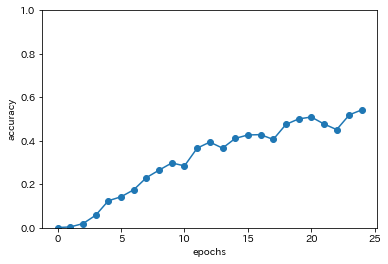

In [24]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from seq2seq import Seq2seq
from peeky_seq2seq import PeekySeq2seq


# データセットの読み込み
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# Reverse input? =================================================
is_reverse = True  # True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
# ================================================================

# ハイパーパラメータの設定
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# Normal or Peeky? ==============================================
model = Seq2seq(vocab_size, wordvec_size, hidden_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('val acc %.3f%%' % (acc * 100))

# グラフの描画
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
plt.show()
